In [191]:
import pandas as pd
from datetime import timedelta
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import resampy
import time
from scipy import interpolate, signal

In [349]:
# read area file
nav = pd.read_excel('C:/Users/Tanya/Downloads/Mondal2.xlsx')[['frame_Numb', 'time', 'arr_dia']]
x = nav['time'].values
v = nav['arr_dia'].values
# interpolate to 20hz
xq = np.arange(x[0], x[-1], 1/30)
vq = np.interp(xq, x, v)
df = pd.DataFrame()
df['time'] = xq
# median filtered area to remove outliers
df['arr_dia'] = signal.medfilt(vq)*3.6

In [350]:
# read velocity file
audio = np.loadtxt('C:/Users/Tanya/Downloads/Mondal2Vel.txt', dtype=('f4, f4'), unpack=True, delimiter='\t')
x = audio[0]
v = audio[1]
# interpolate to 4khz
xq = np.arange(x[0], x[-1], 1/4000)
vq = np.interp(xq, x, v)
aud = pd.DataFrame()
aud['time'] = xq
aud['vel'] = vq
aud = aud.set_index('time')
# area dataframe is trimmed to match time limits of velocity dataframe
df = df.set_index('time')[aud.index[0]:aud.index[-1]]

In [351]:
# segment velocity dataframe with respect to times corresponding to the frames
frame_time = df.index
fds = [0]
for i in range(len(frame_time)-1):
    segment = aud[frame_time[i]: frame_time[i+1]]
    N = len(segment)
    if N>0:
        # take fft of the segment
        fft = np.fft.fft(segment['vel'].values)
        fft = 2.0/N * np.abs(fft[0:N//2])
        freq = np.fft.fftfreq(N, 1/4000)[:N//2]
        indices, _ = signal.find_peaks(fft, prominence=0.0001)
        # calculate mean frequency from the fft
        fd = np.sum(np.multiply(fft[indices], freq[indices]))/np.sum(fft[indices])
        fds.append(fd)

df['fd'] = fds
# calculate velocity
probe_angle = 57
df['vel'] = (1580*np.array(fds)*100)/(2*8*10**6*(np.cos(np.deg2rad(probe_angle))))
df = df[df.index[1]:]

In [352]:
# multiply area and velocity to get volume flow
df['vol_flow'] = np.multiply(df['arr_dia'].values,df['vel'].values)

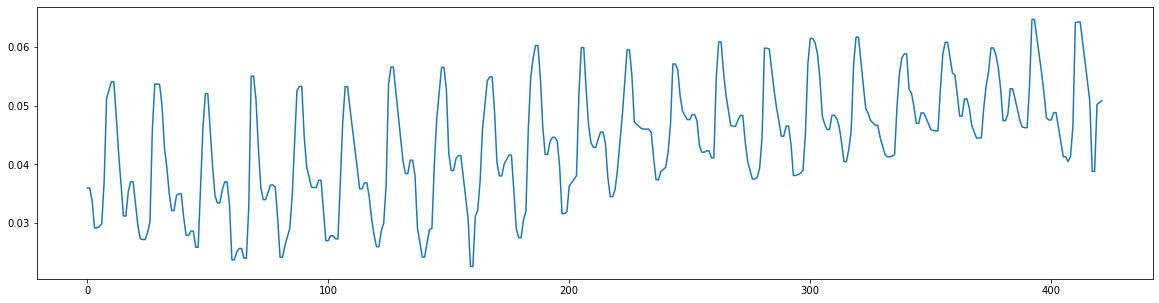

In [353]:
plt.figure(figsize=(20,5))
plt.plot(df['arr_dia'].values[:int(len(df)/4)])

In [354]:
# read pressure file
pres = pd.DataFrame(np.array(np.loadtxt('C:/Users/Tanya/Downloads/M2p.txt', dtype=('f4, f4'), unpack=True, delimiter='\t')).T, columns=['time', 'pres'])
aud['pres'] = np.interp(aud.index, pres['time'], pres['pres'])

Peak frequencies: [0.   1.53 3.07 4.83 6.24 7.82 9.45]


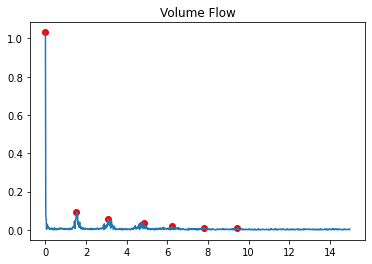

In [355]:
# take fft of volume flow
N = len(df)
fft_vol_flow = np.fft.fft(df['vol_flow'].values)
fft_vol_flow = 2.0/N * np.abs(fft_vol_flow[0:N//2])
freq_vol_flow = np.fft.fftfreq(N, 1/30)[:N//2]
indices, _ = signal.find_peaks(fft_vol_flow, distance=50)
new_inx = np.sort(np.array(fft_vol_flow[indices]).argsort()[-7:][::-1])[1:]

plt.title('Volume Flow')
plt.plot(freq_vol_flow, fft_vol_flow)
plt.scatter(freq_vol_flow[indices][new_inx], fft_vol_flow[indices][new_inx], color='r')
plt.scatter(0,fft_vol_flow[0], color='r')

freq = np.append(0, freq_vol_flow[indices][new_inx])
vol_peaks = np.append(fft_vol_flow[0], fft_vol_flow[indices][new_inx])

print('Peak frequencies: '+ str(np.round(freq,2)))

Peak frequencies: [0.   1.58 3.11 4.69 6.21 7.79 9.38]


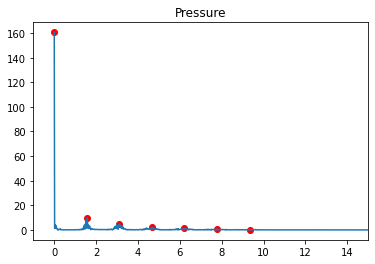

In [356]:
# fft of pressure
N = len(aud)
fft_pres = np.fft.fft(aud['pres'].values)
fft_pres = 2.0/N * np.abs(fft_pres[0:N//2])
freq_pres = np.fft.fftfreq(N, 1/4000)[:N//2]
indices, _ = signal.find_peaks(fft_pres, distance=50)
new_inx = np.sort(np.array(fft_pres[indices]).argsort()[-7:][::-1])[1:]

plt.title('Pressure')
plt.plot(freq_pres, fft_pres)
plt.scatter(freq_pres[indices][new_inx], fft_pres[indices][new_inx], color='r')
plt.scatter(0, fft_pres[0], color='r')
plt.xlim(-1,15)

pres_peaks = np.append(fft_pres[0], fft_pres[indices][new_inx])

print('Peak frequencies: '+ str(np.round(np.append(0, freq_pres[indices][new_inx]),2)))

Mean: 142.8068272705348


,freq,vol_pks,pres_pks,impedance
0,0.000000,1.032284,160.672220,155.647308
1,1.528436,0.091696,9.790078,106.766655
2,3.074645,0.057216,4.775018,83.456636
3,4.834123,0.038746,2.262179,58.384841
4,6.238152,0.019947,1.400951,70.234174
5,7.819905,0.010846,0.707646,65.245993
6,9.454976,0.008787,0.260170,29.607719


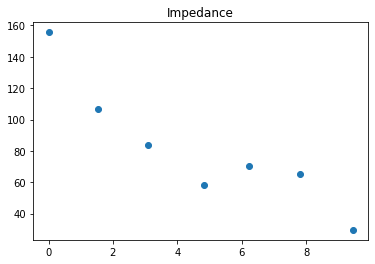

In [357]:
pk = pd.DataFrame()
pk['freq'] = freq
pk['vol_pks'] = vol_peaks
pk['pres_pks'] = pres_peaks
# Divide peaks of pressure by those of volume flow to get impedance
pk['impedance'] = np.divide(pres_peaks, vol_peaks)

print('Mean: '+str(pk['pres_pks'].mean()/pk['vol_pks'].mean()))
plt.title('Impedance')
plt.scatter(pk['freq'], pk['impedance'])
pk

In [362]:
z = (pk['impedance'].values[[0, 2, 3, 4]])**2
k = (pk['freq'].values[[0, 2, 3, 4]] * (2*np.pi))**2

X = np.array([[1,k[0]**2, k[0], z[0]*k[0]], [1,k[1]**2, k[1], z[1]*k[1]], [1,k[2]**2, k[2], z[2]*k[2]], [1,k[3]**2, k[3], z[3]*k[3]]])
y = np.linalg.inv(X)@z

# c is used for conversion from mmhg to SI units for all parameters
c = 10**6/0.0075
print("Results (respective units) from sample data used (this is to demonstrate the method):")
print("L is:")
L= np.sqrt(-y[1]/y[3])
print(L*c)
print('\n')

R1= (np.sqrt(y[2]+ 2*L*np.sqrt(-y[0]*y[3]))- L)/np.sqrt(-y[3])

R2= np.sqrt(y[0])- R1

print("R1 is:")
print(R1*c)
print('\n')

print("R2 is:")
print(R2*c)
print('\n')

C= np.sqrt(-y[3]) /R2
print("C is:")
print(C*(1/c))
print('\n')

Results (respective units) from sample data used (this is to demonstrate the method):
L is:
375466899.93500173


R1 is:
2158003468.000758


R2 is:
18594970951.161602


C is:
2.9423404360416455e-12




In [346]:
L, R1, R2, C

(19.405742608664674,
 -673.4430636767789,
 1089.4883553733473,
 1.6545268759731855e-05)